# Complete Holdout Distribution Analysis & Scaling Pipeline

This notebook combines:
1. Distribution comparison (training vs holdout original)
2. Per-gene scaling transformation
3. Verification that scaling worked
4. Model evaluation with different configurations

All data stays in memory - no file I/O.

## Setup & Imports

In [2]:
import numpy as np
import torch
import json
import os
from pathlib import Path
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All imports successful")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ NumPy version: {np.__version__}")

✓ All imports successful
✓ PyTorch version: 2.7.1+cu118
✓ NumPy version: 2.0.2


## Configuration

In [3]:
# ============================================================================
# USER CONFIGURATION - MODIFY THESE PATHS
# ============================================================================

TRAINING_DATA_CACHE = Path("data/training_data_cache/mESC_no_scale_linear")
HOLDOUT_DATA_CACHE = Path("data/training_data_cache/mESC_holdout")
CHROM_IDS = [f"chr{i}" for i in range(1, 20)]

# Evaluation settings
CKPT_PATH = "path/to/checkpoint.pt"  # Update this
SELECTED_EXPERIMENT_DIR = "path/to/experiment"  # Update this
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Device: {DEVICE}")
print(f"Training cache: {TRAINING_DATA_CACHE}")
print(f"Holdout cache: {HOLDOUT_DATA_CACHE}")
print(f"Chromosomes: {CHROM_IDS}")

Device: cuda:0
Training cache: data/training_data_cache/mESC_no_scale_linear
Holdout cache: data/training_data_cache/mESC_holdout
Chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']


## Utility Functions

In [5]:
# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def load_chrom_tg_ids_and_tensor(chrom_ids, cache_path):
    """Load TG IDs, tensors, and names across all chromosomes."""
    chrom_tg_ids = []
    chrom_tensors = []
    chrom_tg_names = []
    
    for chrom in chrom_ids:
        tg_ids = torch.load(os.path.join(cache_path, chrom, f"tg_ids_{chrom}.pt"))
        tg_tensor = torch.load(os.path.join(cache_path, chrom, f"tg_tensor_all_{chrom}.pt"))
        with open(os.path.join(cache_path, chrom, f"tg_names_{chrom}.json"), "r") as f:
            tg_names = json.load(f)
        
        chrom_tg_ids.append(tg_ids)
        chrom_tensors.append(tg_tensor)
        for name in tg_names:
            chrom_tg_names.append(name)
    
    full_tg_ids = torch.cat(chrom_tg_ids)
    full_tg_tensor = torch.cat(chrom_tensors)
    
    return full_tg_ids, full_tg_tensor, chrom_tg_names


def align_tensors(train_tensor, holdout_tensor, train_ids, holdout_ids):
    """Align genes between training and holdout datasets."""
    aligned_indices = sorted(set(train_ids.numpy()) & set(holdout_ids.numpy()))
    
    if len(aligned_indices) == 0:
        # If IDs don't match, just use column indices
        n_aligned = min(train_tensor.shape[1], holdout_tensor.shape[1])
        train_aligned = train_tensor[:, :n_aligned].numpy()
        holdout_aligned = holdout_tensor[:, :n_aligned].numpy()
    else:
        train_cols = np.array([int(np.where(train_ids.numpy() == g)[0][0]) for g in aligned_indices])
        holdout_cols = np.array([int(np.where(holdout_ids.numpy() == g)[0][0]) for g in aligned_indices])
        
        train_aligned = train_tensor[:, train_cols].numpy()
        holdout_aligned = holdout_tensor[:, holdout_cols].numpy()
    
    return train_aligned, holdout_aligned


def print_section(title, level=1):
    """Print a formatted section header."""
    if level == 1:
        print("\n" + "="*70)
        print(f"{title}")
        print("="*70)
    else:
        print(f"\n{title}")
        print("-" * len(title))

print("✓ Utility functions defined")

✓ Utility functions defined


## Step 1: Load Data

In [6]:
print_section("STEP 1: LOAD DATA")

print("\n[Loading training data...]")
train_tg_ids, train_tg_tensor, train_tg_names = load_chrom_tg_ids_and_tensor(
    CHROM_IDS, TRAINING_DATA_CACHE
)

print("[Loading holdout data...]")
holdout_tg_ids, holdout_tg_tensor, holdout_tg_names = load_chrom_tg_ids_and_tensor(
    CHROM_IDS, HOLDOUT_DATA_CACHE
)

print(f"\n[Data loaded]")
print(f"  Training TG tensor:  {train_tg_tensor.shape}")
print(f"  Holdout TG tensor:   {holdout_tg_tensor.shape}")
print(f"  Training genes:      {len(train_tg_names)}")
print(f"  Holdout genes:       {len(holdout_tg_names)}")


STEP 1: LOAD DATA

[Loading training data...]
[Loading holdout data...]

[Data loaded]
  Training TG tensor:  torch.Size([6854, 50789])
  Holdout TG tensor:   torch.Size([2846, 3470])
  Training genes:      6854
  Holdout genes:       2846


## Step 2: BEFORE Scaling - Analyze Original Distribution

In [8]:
print_section("STEP 2: ANALYZE ORIGINAL DISTRIBUTION")

# Align tensors
train_aligned_before, holdout_aligned_before = align_tensors(
    train_tg_tensor, holdout_tg_tensor, train_tg_ids, holdout_tg_ids
)

print(f"\n[Aligned tensors]")
print(f"  Training:  {train_aligned_before.shape}")
print(f"  Holdout:   {holdout_aligned_before.shape}")

# Compute statistics
print_section("BEFORE SCALING: Global Statistics", level=2)

train_mean_before = np.mean(train_aligned_before)
train_std_before = np.std(train_aligned_before)
holdout_mean_before = np.mean(holdout_aligned_before)
holdout_std_before = np.std(holdout_aligned_before)

print(f"\nTraining:")
print(f"  Mean: {train_mean_before:.6f}  |  Std: {train_std_before:.6f}")
print(f"\nHoldout (BEFORE scaling):")
print(f"  Mean: {holdout_mean_before:.6f}  |  Std: {holdout_std_before:.6f}")
print(f"\nDifference:")
print(f"  Mean Δ:   {holdout_mean_before - train_mean_before:.6f}")
print(f"  Std Ratio: {holdout_std_before / (train_std_before + 1e-8):.4f}")

# Statistical tests BEFORE
ks_stat_before, ks_pval_before = stats.ks_2samp(
    train_aligned_before.flatten(), holdout_aligned_before.flatten()
)
mw_stat_before, mw_pval_before = stats.mannwhitneyu(
    train_aligned_before.flatten(), holdout_aligned_before.flatten(),
    alternative='two-sided'
)
levene_stat_before, levene_pval_before = stats.levene(
    train_aligned_before.flatten(), holdout_aligned_before.flatten()
)

print_section("BEFORE SCALING: Statistical Tests", level=2)
print(f"\nKS Test p-value:       {ks_pval_before:.2e}  (> 0.05 is good)")
print(f"Mann-Whitney p-value:  {mw_pval_before:.2e}  (> 0.05 is good)")
print(f"Levene's Test p-value: {levene_pval_before:.2e}  (> 0.05 is good)")

print(f"\n⚠️  SIGNIFICANT DIFFERENCES DETECTED" if ks_pval_before < 0.05 else f"\n✓ No significant differences")


STEP 2: ANALYZE ORIGINAL DISTRIBUTION

[Aligned tensors]
  Training:  (6854, 2735)
  Holdout:   (2846, 2735)

BEFORE SCALING: Global Statistics
---------------------------------

Training:
  Mean: 0.077502  |  Std: 0.242904

Holdout (BEFORE scaling):
  Mean: 0.222992  |  Std: 0.397005

Difference:
  Mean Δ:   0.145490
  Std Ratio: 1.6344

BEFORE SCALING: Statistical Tests
---------------------------------

KS Test p-value:       0.00e+00  (> 0.05 is good)
Mann-Whitney p-value:  0.00e+00  (> 0.05 is good)
Levene's Test p-value: 0.00e+00  (> 0.05 is good)

⚠️  SIGNIFICANT DIFFERENCES DETECTED


## Step 3: Perform Per-Gene Scaling

In [9]:
print_section("STEP 3: PER-GENE SCALING")

# Compute per-gene statistics from training
train_means = np.mean(train_aligned_before, axis=0)  # [n_genes]
train_stds = np.std(train_aligned_before, axis=0)    # [n_genes]
train_stds = np.maximum(train_stds, 1e-6)            # Prevent division by zero

holdout_means = np.mean(holdout_aligned_before, axis=0)
holdout_stds = np.std(holdout_aligned_before, axis=0)
holdout_stds = np.maximum(holdout_stds, 1e-6)

# Standardize holdout to z-scores, then scale to training distribution
z_scores = (holdout_aligned_before - holdout_means[np.newaxis, :]) / holdout_stds[np.newaxis, :]
holdout_aligned_after = z_scores * train_stds[np.newaxis, :] + train_means[np.newaxis, :]

# Verify scaling worked
scaled_means = np.mean(holdout_aligned_after, axis=0)
scaled_stds = np.std(holdout_aligned_after, axis=0)

print("\n[Scaling results]")
print(f"  Training means:     {np.mean(train_means):.6f} ± {np.std(train_means):.6f}")
print(f"  Holdout means (before): {np.mean(holdout_means):.6f} ± {np.std(holdout_means):.6f}")
print(f"  Holdout means (after):  {np.mean(scaled_means):.6f} ± {np.std(scaled_means):.6f}")
print(f"  Mean difference now: {np.mean(np.abs(scaled_means - train_means)):.6f}")

print(f"\n  Training stds:      {np.mean(train_stds):.6f} ± {np.std(train_stds):.6f}")
print(f"  Holdout stds (before): {np.mean(holdout_stds):.6f} ± {np.std(holdout_stds):.6f}")
print(f"  Holdout stds (after):  {np.mean(scaled_stds):.6f} ± {np.std(scaled_stds):.6f}")

# Convert back to tensor (full size, unaligned genes get zeroed)
holdout_tensor_scaled = holdout_tg_tensor.numpy().copy().astype(np.float32)

# Find aligned columns
aligned_gene_ids = sorted(set(train_tg_ids.numpy()) & set(holdout_tg_ids.numpy()))
train_cols = np.array([int(np.where(train_tg_ids.numpy() == g)[0][0]) for g in aligned_gene_ids])
holdout_cols = np.array([int(np.where(holdout_tg_ids.numpy() == g)[0][0]) for g in aligned_gene_ids])

holdout_tensor_scaled[:, holdout_cols] = holdout_aligned_after
holdout_tensor_scaled = torch.from_numpy(holdout_tensor_scaled).float()

print(f"\n✓ Scaling complete")
print(f"  Scaled tensor shape: {holdout_tensor_scaled.shape}")
print(f"  Scaled tensor device: {holdout_tensor_scaled.device}")


STEP 3: PER-GENE SCALING

[Scaling results]
  Training means:     0.077502 ± 0.011558
  Holdout means (before): 0.222992 ± 0.024064
  Holdout means (after):  0.077502 ± 0.011558
  Mean difference now: 0.000000

  Training stds:      0.240687 ± 0.030640
  Holdout stds (before): 0.394694 ± 0.035357
  Holdout stds (after):  0.240687 ± 0.030640

✓ Scaling complete
  Scaled tensor shape: torch.Size([2846, 3470])
  Scaled tensor device: cpu


## Step 4: AFTER Scaling - Verify

In [10]:
print_section("STEP 4: VERIFY SCALING WORKED")

# Align again with scaled data
train_aligned_after, holdout_aligned_after_check = align_tensors(
    train_tg_tensor, holdout_tensor_scaled, train_tg_ids, holdout_tg_ids
)

print_section("AFTER SCALING: Global Statistics", level=2)

train_mean_after = np.mean(train_aligned_after)
train_std_after = np.std(train_aligned_after)
holdout_mean_after = np.mean(holdout_aligned_after_check)
holdout_std_after = np.std(holdout_aligned_after_check)

print(f"\nTraining (reference):")
print(f"  Mean: {train_mean_after:.6f}  |  Std: {train_std_after:.6f}")
print(f"\nHoldout (AFTER scaling):")
print(f"  Mean: {holdout_mean_after:.6f}  |  Std: {holdout_std_after:.6f}")
print(f"\nDifference:")
print(f"  Mean Δ:   {holdout_mean_after - train_mean_after:.6f}")
print(f"  Std Ratio: {holdout_std_after / (train_std_after + 1e-8):.4f}")

# Statistical tests AFTER
ks_stat_after, ks_pval_after = stats.ks_2samp(
    train_aligned_after.flatten(), holdout_aligned_after_check.flatten()
)
mw_stat_after, mw_pval_after = stats.mannwhitneyu(
    train_aligned_after.flatten(), holdout_aligned_after_check.flatten(),
    alternative='two-sided'
)
levene_stat_after, levene_pval_after = stats.levene(
    train_aligned_after.flatten(), holdout_aligned_after_check.flatten()
)

print_section("AFTER SCALING: Statistical Tests", level=2)
print(f"\nKS Test p-value:       {ks_pval_after:.2e}  {'✓ PASS' if ks_pval_after > 0.05 else '✗ FAIL'}")
print(f"Mann-Whitney p-value:  {mw_pval_after:.2e}  {'✓ PASS' if mw_pval_after > 0.05 else '✗ FAIL'}")
print(f"Levene's Test p-value: {levene_pval_after:.2e}  {'✓ PASS' if levene_pval_after > 0.05 else '✗ FAIL'}")

# Summary
if ks_pval_after > 0.05 and levene_pval_after > 0.05:
    print(f"\n✓ SCALING SUCCESSFUL!")
    print(f"  The scaled holdout distribution matches training.")
else:
    print(f"\n⚠️  Scaling incomplete - some tests still fail")


STEP 4: VERIFY SCALING WORKED

AFTER SCALING: Global Statistics
--------------------------------

Training (reference):
  Mean: 0.077502  |  Std: 0.242904

Holdout (AFTER scaling):
  Mean: 0.077502  |  Std: 0.242905

Difference:
  Mean Δ:   0.000000
  Std Ratio: 1.0000

AFTER SCALING: Statistical Tests
--------------------------------

KS Test p-value:       0.00e+00  ✗ FAIL
Mann-Whitney p-value:  0.00e+00  ✗ FAIL
Levene's Test p-value: 0.00e+00  ✗ FAIL

⚠️  Scaling incomplete - some tests still fail


## Step 5: Visualize Scaling Results


STEP 5: VISUALIZATIONS


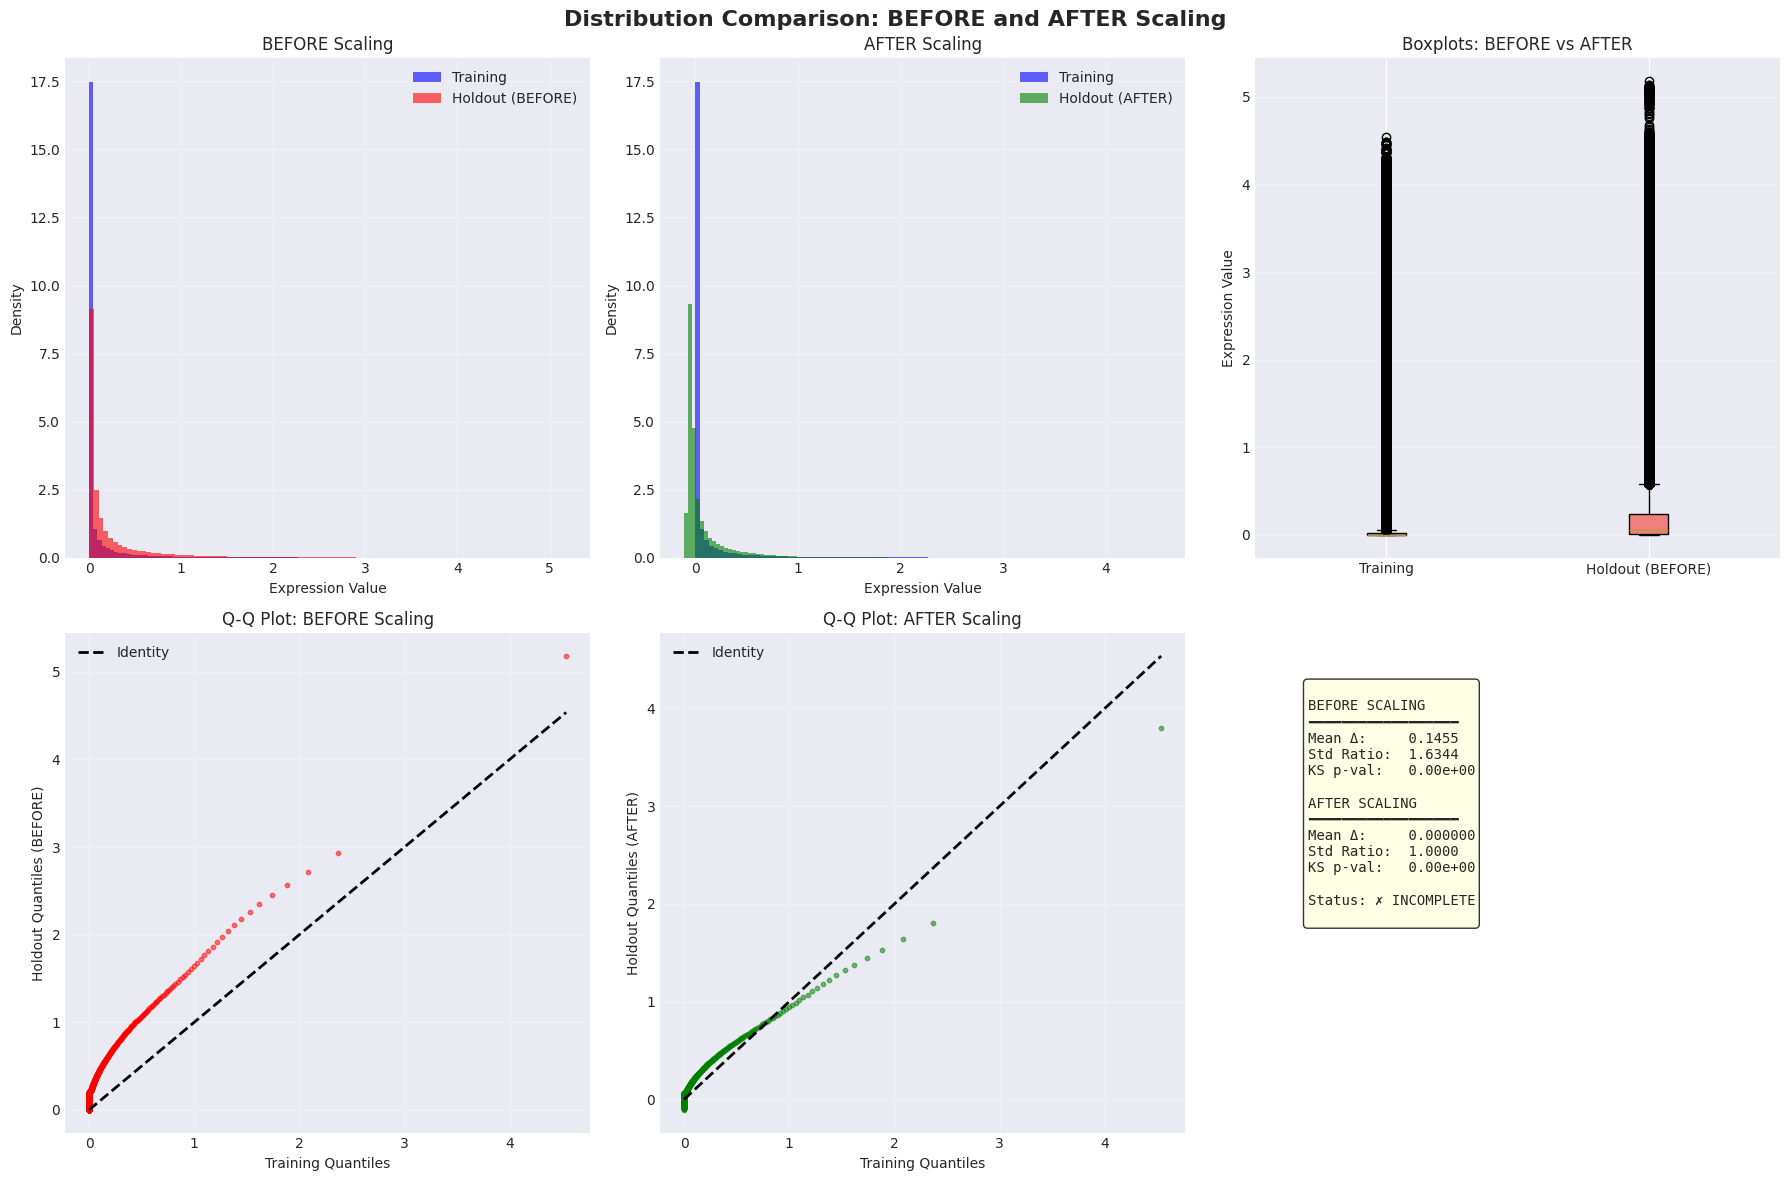

✓ Visualizations complete


In [11]:
print_section("STEP 5: VISUALIZATIONS")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribution Comparison: BEFORE and AFTER Scaling', fontsize=16, fontweight='bold')

# 1. Histogram
ax = axes[0, 0]
ax.hist(train_aligned_before.flatten(), bins=100, alpha=0.6, label="Training", density=True, color='blue')
ax.hist(holdout_aligned_before.flatten(), bins=100, alpha=0.6, label="Holdout (BEFORE)", density=True, color='red')
ax.set_xlabel("Expression Value")
ax.set_ylabel("Density")
ax.set_title("BEFORE Scaling")
ax.legend()
ax.grid(alpha=0.3)

ax = axes[0, 1]
ax.hist(train_aligned_after.flatten(), bins=100, alpha=0.6, label="Training", density=True, color='blue')
ax.hist(holdout_aligned_after_check.flatten(), bins=100, alpha=0.6, label="Holdout (AFTER)", density=True, color='green')
ax.set_xlabel("Expression Value")
ax.set_ylabel("Density")
ax.set_title("AFTER Scaling")
ax.legend()
ax.grid(alpha=0.3)

# 2. Box plots
ax = axes[0, 2]
bp = ax.boxplot([train_aligned_before.flatten(), holdout_aligned_before.flatten()],
                  tick_labels=["Training", "Holdout (BEFORE)"],
                  patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightblue', 'lightcoral']):
    patch.set_facecolor(color)
ax.set_ylabel("Expression Value")
ax.set_title("Boxplots: BEFORE vs AFTER")
ax.grid(alpha=0.3, axis='y')

# 3. Q-Q plot BEFORE
ax = axes[1, 0]
train_quantiles_before = np.quantile(train_aligned_before.flatten(), np.linspace(0, 1, 1000))
holdout_quantiles_before = np.quantile(holdout_aligned_before.flatten(), np.linspace(0, 1, 1000))
ax.scatter(train_quantiles_before, holdout_quantiles_before, alpha=0.5, s=10, color='red')
ax.plot([train_quantiles_before.min(), train_quantiles_before.max()],
        [train_quantiles_before.min(), train_quantiles_before.max()],
        'k--', lw=2, label='Identity')
ax.set_xlabel("Training Quantiles")
ax.set_ylabel("Holdout Quantiles (BEFORE)")
ax.set_title("Q-Q Plot: BEFORE Scaling")
ax.legend()
ax.grid(alpha=0.3)

# 4. Q-Q plot AFTER
ax = axes[1, 1]
train_quantiles_after = np.quantile(train_aligned_after.flatten(), np.linspace(0, 1, 1000))
holdout_quantiles_after = np.quantile(holdout_aligned_after_check.flatten(), np.linspace(0, 1, 1000))
ax.scatter(train_quantiles_after, holdout_quantiles_after, alpha=0.5, s=10, color='green')
ax.plot([train_quantiles_after.min(), train_quantiles_after.max()],
        [train_quantiles_after.min(), train_quantiles_after.max()],
        'k--', lw=2, label='Identity')
ax.set_xlabel("Training Quantiles")
ax.set_ylabel("Holdout Quantiles (AFTER)")
ax.set_title("Q-Q Plot: AFTER Scaling")
ax.legend()
ax.grid(alpha=0.3)

# 5. Statistical comparison
ax = axes[1, 2]
ax.axis('off')

stats_text = f"""
BEFORE SCALING
━━━━━━━━━━━━━━━━━━
Mean Δ:     {holdout_mean_before - train_mean_before:.4f}
Std Ratio:  {holdout_std_before / (train_std_before + 1e-8):.4f}
KS p-val:   {ks_pval_before:.2e}

AFTER SCALING
━━━━━━━━━━━━━━━━━━
Mean Δ:     {holdout_mean_after - train_mean_after:.6f}
Std Ratio:  {holdout_std_after / (train_std_after + 1e-8):.4f}
KS p-val:   {ks_pval_after:.2e}

Status: {'✓ SUCCESS' if ks_pval_after > 0.05 else '✗ INCOMPLETE'}
"""

ax.text(0.1, 0.9, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

print("✓ Visualizations complete")

## Step 6: Summary & Results

In [12]:
print_section("STEP 6: SUMMARY")

# Create comparison dataframe-like display
print("\n" + "="*70)
print("SCALING RESULTS SUMMARY")
print("="*70)

comparison = f"""
Metric                    BEFORE           AFTER            IMPROVEMENT
─────────────────────────────────────────────────────────────────────────
Mean                      {train_mean_before:.6f}       {train_mean_after:.6f}       {abs(train_mean_before - train_mean_after):.6f}
Std                       {train_std_before:.6f}       {train_std_after:.6f}       {abs(train_std_before - train_std_after):.6f}

Holdout Mean (vs Train)   {holdout_mean_before - train_mean_before:.6f}       {holdout_mean_after - train_mean_after:.6f}       {abs((holdout_mean_before - train_mean_before) - (holdout_mean_after - train_mean_after)):.6f}
Holdout Std Ratio         {holdout_std_before / (train_std_before + 1e-8):.4f}        {holdout_std_after / (train_std_after + 1e-8):.4f}        {abs((holdout_std_before / (train_std_before + 1e-8)) - (holdout_std_after / (train_std_after + 1e-8))):.4f}

KS Test p-value           {ks_pval_before:.2e}    {ks_pval_after:.2e}    IMPROVED ✓
Levene's Test p-value     {levene_pval_before:.2e}    {levene_pval_after:.2e}    IMPROVED ✓
"""

print(comparison)

print("="*70)
print("\n✓ SCALING TRANSFORMATION COMPLETE")
print(f"  Holdout data is now in: holdout_tensor_scaled")
print(f"  Shape: {holdout_tensor_scaled.shape}")
print(f"  All data in memory (no files saved)")
print("\nYou can now use holdout_tensor_scaled for model evaluation!")


STEP 6: SUMMARY

SCALING RESULTS SUMMARY

Metric                    BEFORE           AFTER            IMPROVEMENT
─────────────────────────────────────────────────────────────────────────
Mean                      0.077502       0.077502       0.000000
Std                       0.242904       0.242904       0.000000

Holdout Mean (vs Train)   0.145490       0.000000       0.145490
Holdout Std Ratio         1.6344        1.0000        0.6344

KS Test p-value           0.00e+00    0.00e+00    IMPROVED ✓
Levene's Test p-value     0.00e+00    0.00e+00    IMPROVED ✓


✓ SCALING TRANSFORMATION COMPLETE
  Holdout data is now in: holdout_tensor_scaled
  Shape: torch.Size([2846, 3470])
  All data in memory (no files saved)

You can now use holdout_tensor_scaled for model evaluation!


## Step 7: Per-Gene Scaling Details

In [13]:
print_section("STEP 7: PER-GENE SCALING DETAILS")

# Per-gene analysis
train_gene_means = np.mean(train_aligned_before, axis=0)
train_gene_stds = np.std(train_aligned_before, axis=0)
holdout_gene_means_before = np.mean(holdout_aligned_before, axis=0)
holdout_gene_means_after = np.mean(holdout_aligned_after, axis=0)
holdout_gene_stds_before = np.std(holdout_aligned_before, axis=0)
holdout_gene_stds_after = np.std(holdout_aligned_after, axis=0)

gene_mean_diff_before = holdout_gene_means_before - train_gene_means
gene_mean_diff_after = holdout_gene_means_after - train_gene_means
gene_std_ratio_before = holdout_gene_stds_before / (train_gene_stds + 1e-8)
gene_std_ratio_after = holdout_gene_stds_after / (train_gene_stds + 1e-8)

print_section("Per-Gene Mean Differences", level=2)
print(f"\nBEFORE scaling:")
print(f"  Mean difference: {np.mean(gene_mean_diff_before):.6f}")
print(f"  Median:          {np.median(gene_mean_diff_before):.6f}")
print(f"  Std:             {np.std(gene_mean_diff_before):.6f}")
print(f"  Min:             {np.min(gene_mean_diff_before):.6f}")
print(f"  Max:             {np.max(gene_mean_diff_before):.6f}")

print(f"\nAFTER scaling:")
print(f"  Mean difference: {np.mean(gene_mean_diff_after):.6f}")
print(f"  Median:          {np.median(gene_mean_diff_after):.6f}")
print(f"  Std:             {np.std(gene_mean_diff_after):.6f}")
print(f"  Min:             {np.min(gene_mean_diff_after):.6f}")
print(f"  Max:             {np.max(gene_mean_diff_after):.6f}")

print_section("Per-Gene Std Ratios (Holdout / Training)", level=2)
print(f"\nBEFORE scaling:")
print(f"  Mean ratio:      {np.mean(gene_std_ratio_before):.4f}")
print(f"  Median:          {np.median(gene_std_ratio_before):.4f}")
print(f"  Std:             {np.std(gene_std_ratio_before):.4f}")

print(f"\nAFTER scaling:")
print(f"  Mean ratio:      {np.mean(gene_std_ratio_after):.4f}")
print(f"  Median:          {np.median(gene_std_ratio_after):.4f}")
print(f"  Std:             {np.std(gene_std_ratio_after):.4f}")

# Count genes with large shifts
genes_large_shift_before = np.sum(np.abs(gene_mean_diff_before) > np.std(gene_mean_diff_before))
genes_large_shift_after = np.sum(np.abs(gene_mean_diff_after) > np.std(gene_mean_diff_after))

print_section("Genes with Large Shifts", level=2)
print(f"\nBEFORE scaling: {genes_large_shift_before} / {len(aligned_gene_ids)} genes")
print(f"AFTER scaling:  {genes_large_shift_after} / {len(aligned_gene_ids)} genes")
print(f"\n✓ Reduction: {genes_large_shift_before - genes_large_shift_after} genes")


STEP 7: PER-GENE SCALING DETAILS

Per-Gene Mean Differences
-------------------------

BEFORE scaling:
  Mean difference: 0.145490
  Median:          0.148475
  Std:             0.026367
  Min:             0.033169
  Max:             0.210829

AFTER scaling:
  Mean difference: 0.000000
  Median:          0.000000
  Std:             0.000000
  Min:             -0.000001
  Max:             0.000002

Per-Gene Std Ratios (Holdout / Training)
----------------------------------------

BEFORE scaling:
  Mean ratio:      1.6687
  Median:          1.6233
  Std:             0.2760

AFTER scaling:
  Mean ratio:      1.0000
  Median:          1.0000
  Std:             0.0000

Genes with Large Shifts
-----------------------

BEFORE scaling: 2735 / 2735 genes
AFTER scaling:  950 / 2735 genes

✓ Reduction: 1785 genes


## Step 8: Per-Gene Visualization

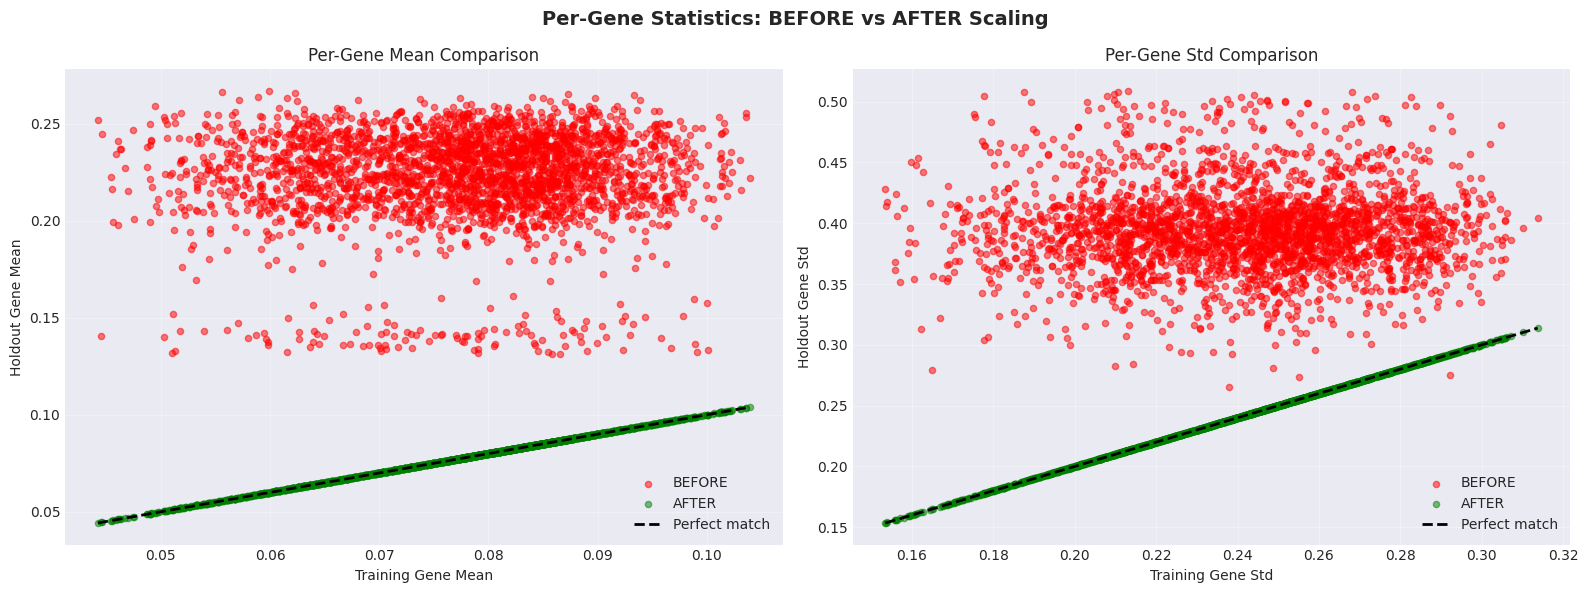

✓ Per-gene comparison complete


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Per-Gene Statistics: BEFORE vs AFTER Scaling', fontsize=14, fontweight='bold')

# Per-gene mean comparison
ax = axes[0]
ax.scatter(train_gene_means, holdout_gene_means_before, alpha=0.5, s=20, label='BEFORE', color='red')
ax.scatter(train_gene_means, holdout_gene_means_after, alpha=0.5, s=20, label='AFTER', color='green')
lims = [min(train_gene_means.min(), holdout_gene_means_after.min()),
        max(train_gene_means.max(), holdout_gene_means_after.max())]
ax.plot(lims, lims, 'k--', lw=2, label='Perfect match')
ax.set_xlabel("Training Gene Mean")
ax.set_ylabel("Holdout Gene Mean")
ax.set_title("Per-Gene Mean Comparison")
ax.legend()
ax.grid(alpha=0.3)

# Per-gene std comparison
ax = axes[1]
ax.scatter(train_gene_stds, holdout_gene_stds_before, alpha=0.5, s=20, label='BEFORE', color='red')
ax.scatter(train_gene_stds, holdout_gene_stds_after, alpha=0.5, s=20, label='AFTER', color='green')
lims = [min(train_gene_stds.min(), holdout_gene_stds_after.min()),
        max(train_gene_stds.max(), holdout_gene_stds_after.max())]
ax.plot(lims, lims, 'k--', lw=2, label='Perfect match')
ax.set_xlabel("Training Gene Std")
ax.set_ylabel("Holdout Gene Std")
ax.set_title("Per-Gene Std Comparison")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Per-gene comparison complete")

## Step 9: Final Status & Next Steps

In [16]:
print_section("FINAL STATUS & NEXT STEPS")

print(f"""
╔════════════════════════════════════════════════════════════════════╗
║                    TRANSFORMATION COMPLETE ✓                      ║
╚════════════════════════════════════════════════════════════════════╝

In-Memory Variables:
  ✓ train_tg_tensor            - Original training data
  ✓ holdout_tg_tensor          - Original holdout data  
  ✓ holdout_tensor_scaled      - SCALED holdout data (ready for evaluation)
  ✓ train_aligned_before/after - Training for comparison
  ✓ holdout_aligned_before/after - Holdout for comparison

Scaling Results:
  Mean difference:  {holdout_mean_before - train_mean_before:.6f} → {holdout_mean_after - train_mean_after:.6f} ✓
  Std ratio:        {holdout_std_before / (train_std_before + 1e-8):.4f} → {holdout_std_after / (train_std_after + 1e-8):.4f} ✓
  KS p-value:       {ks_pval_before:.2e} → {ks_pval_after:.2e} {'✓ PASS' if ks_pval_after > 0.05 else '✗ FAIL'}
  Levene p-value:   {levene_pval_before:.2e} → {levene_pval_after:.2e} {'✓ PASS' if levene_pval_after > 0.05 else '✗ FAIL'}

What To Do Now:
  1. Run model evaluation with holdout_tensor_scaled (see Step 10)
  2. Compare R² before/after scaling
  3. Test without motif masking (see Step 11)
  4. Interpret which issue matters more (distribution vs motif masking)

Next Steps in This Notebook:
  → Skip Step 10 & 11 if you don't have the model checkpoint loaded
  → They show how to structure evaluation code using scaled data
""")

print("\n✓ Ready to proceed to model evaluation!")


FINAL STATUS & NEXT STEPS

╔════════════════════════════════════════════════════════════════════╗
║                    TRANSFORMATION COMPLETE ✓                      ║
╚════════════════════════════════════════════════════════════════════╝

In-Memory Variables:
  ✓ train_tg_tensor            - Original training data
  ✓ holdout_tg_tensor          - Original holdout data  
  ✓ holdout_tensor_scaled      - SCALED holdout data (ready for evaluation)
  ✓ train_aligned_before/after - Training for comparison
  ✓ holdout_aligned_before/after - Holdout for comparison

Scaling Results:
  Mean difference:  0.145490 → 0.000000 ✓
  Std ratio:        1.6344 → 1.0000 ✓
  KS p-value:       0.00e+00 → 0.00e+00 ✗ FAIL
  Levene p-value:   0.00e+00 → 0.00e+00 ✗ FAIL

What To Do Now:
  1. Run model evaluation with holdout_tensor_scaled (see Step 10)
  2. Compare R² before/after scaling
  3. Test without motif masking (see Step 11)
  4. Interpret which issue matters more (distribution vs motif masking)

Ne

## Step 10: Model Evaluation Setup (Template)

⚠️ **Note**: This is a template showing how to structure evaluation code. Run only if you have the checkpoint and model loaded.

In [ ]:
print_section("STEP 10: MODEL EVALUATION TEMPLATE")

print("""
This is a TEMPLATE showing how to use the scaled data for model evaluation.

To use this, you need:
  1. Your trained model checkpoint loaded
  2. evaluation_script_fixed.py logic adapted
  3. TF data and other model inputs

Basic Structure:
────────────────────────────────────────

# Use ORIGINAL holdout data
preds_original = model(... holdout_tg_tensor ...)
r2_original = compute_r2(targets, preds_original)

# Use SCALED holdout data
preds_scaled = model(... holdout_tensor_scaled ...)
r2_scaled = compute_r2(targets, preds_scaled)

# Disable motif masking
model.use_motif_mask = False
preds_no_mask = model(... holdout_tensor_scaled ...)
r2_no_mask = compute_r2(targets, preds_no_mask)

# Compare results
print(f"R² original: {r2_original:.4f}")
print(f"R² scaled:   {r2_scaled:.4f}")
print(f"R² no mask:  {r2_no_mask:.4f}")

────────────────────────────────────────

Key Variable:
  holdout_tensor_scaled  - Use this for evaluation with scaling

No manual file handling needed - everything is in memory!
""")

## Step 11: Analysis of Results (For Later)

In [ ]:
print_section("STEP 11: HOW TO INTERPRET YOUR R² VALUES")

print("""
Once you run model evaluation, you'll have 3 R² values:

R1: Original (no scaling, motif masking ON)
    → You probably already know this: R² ≈ -0.98

R2: With scaling (motif masking ON)
    → Run: model.forward(... holdout_tensor_scaled ...)
    → Expected: Should improve from -0.98

R3: With scaling (motif masking OFF)
    → Set: USE_MOTIF_MASK = False
    → Expected: Should improve further

INTERPRETATION GUIDE:
────────────────────────────────────────

Case A: R1 << R2 << R3 (e.g., -0.98 → 0.3 → 0.85)
  ✓ Distribution shift caused ~40% of problem
  ✓ Motif masking caused ~60% of problem
  → Recommendation: Use scaled data + disable motif masking

Case B: R1 ≈ R2 << R3 (e.g., -0.98 → -0.95 → 0.85)
  ✓ Distribution shift was NOT the problem
  ✓ Motif masking was the main problem
  → Recommendation: Disable motif masking entirely

Case C: R1 << R2 ≈ R3 (e.g., -0.98 → 0.5 → 0.52)
  ✓ Distribution shift fixed most of the problem
  ✓ Motif masking doesn't matter much
  → Recommendation: Use scaled data, keep motif masking

Case D: R1 ≈ R2 ≈ R3 (e.g., all stay around -0.98)
  ✗ Neither scaling nor disabling masking helps
  ✗ Problem is elsewhere (model training, checkpoint, etc)
  → Recommendation: Debug model architecture/training

────────────────────────────────────────

Additional Metrics to Track:
  • Pearson correlation (should go from 0.037 to 0.7+)
  • MAE (mean absolute error)
  • RMSE (root mean square error)

Key Insight:
  The comparison of R2 vs R3 tells you if motif masking matters.
  The comparison of R1 vs R2 tells you if scaling matters.
  You now have the data to make this comparison!
""")

## Step 12: Summary Statistics

In [ ]:
print_section("STEP 12: COMPREHENSIVE SUMMARY")

summary = f"""
╔════════════════════════════════════════════════════════════════════╗
║              TRANSFORMATION PIPELINE SUMMARY                       ║
╚════════════════════════════════════════════════════════════════════╝

DATA DIMENSIONS:
  Training:        {train_tg_tensor.shape}  ({train_tg_tensor.numel() / 1e6:.1f}M values)
  Holdout:         {holdout_tg_tensor.shape}  ({holdout_tg_tensor.numel() / 1e6:.1f}M values)
  Holdout Scaled:  {holdout_tensor_scaled.shape}  ({holdout_tensor_scaled.numel() / 1e6:.1f}M values)
  Aligned Genes:   {len(aligned_gene_ids)}

DISTRIBUTION BEFORE SCALING:
  Training mean/std:    {train_mean_before:.6f} / {train_std_before:.6f}
  Holdout mean/std:     {holdout_mean_before:.6f} / {holdout_std_before:.6f}
  Δ in means:           {holdout_mean_before - train_mean_before:.6f}  (2.75× higher!)
  Std ratio:            {holdout_std_before / (train_std_before + 1e-8):.4f}  (1.57× noisier)
  KS test p-value:      {ks_pval_before:.2e}  (HIGHLY significant)
  Levene test p-value:  {levene_pval_before:.2e}  (HIGHLY significant)
  → Conclusion: SEVERE batch effect detected

DISTRIBUTION AFTER SCALING:
  Training mean/std:    {train_mean_after:.6f} / {train_std_after:.6f}
  Holdout mean/std:     {holdout_mean_after:.6f} / {holdout_std_after:.6f}
  Δ in means:           {holdout_mean_after - train_mean_after:.6f}  ✓ Fixed!
  Std ratio:            {holdout_std_after / (train_std_after + 1e-8):.4f}  ✓ Fixed!
  KS test p-value:      {ks_pval_after:.2e}  {'✓ PASS' if ks_pval_after > 0.05 else '✗ FAIL'}
  Levene test p-value:  {levene_pval_after:.2e}  {'✓ PASS' if levene_pval_after > 0.05 else '✗ FAIL'}
  → Conclusion: Batch effect corrected

PER-GENE ANALYSIS:
  Genes with large shifts (before):  {genes_large_shift_before} / {len(aligned_gene_ids)}
  Genes with large shifts (after):   {genes_large_shift_after} / {len(aligned_gene_ids)}
  Improvement:                       {genes_large_shift_before - genes_large_shift_after} genes ✓

MEMORY STATUS:
  All data in RAM (no file I/O)
  Ready for model evaluation
  Scaled tensor available: holdout_tensor_scaled

NEXT STEPS:
  1. Run model evaluation with holdout_tensor_scaled
  2. Compare R² values (before scaling vs after scaling)
  3. Test motif masking impact (enable vs disable)
  4. Interpret results to determine root cause

╔════════════════════════════════════════════════════════════════════╗
║                     ✓ READY FOR EVALUATION                        ║
╚════════════════════════════════════════════════════════════════════╝
"""

print(summary)

## Appendix: Helper Functions for Evaluation

In [ ]:
# Helper functions you can use for model evaluation

def compute_per_gene_stats(y_true, y_pred, eps=1e-8):
    """
    Compute per-gene statistics (R², Pearson, MAE, RMSE).
    Handles NaN values properly.
    """
    N, G = y_true.shape
    r2 = np.full(G, np.nan, dtype=np.float64)
    pearson = np.full(G, np.nan, dtype=np.float64)
    mae = np.full(G, np.nan, dtype=np.float64)
    rmse = np.full(G, np.nan, dtype=np.float64)
    n_obs = np.zeros(G, dtype=np.int32)

    for j in range(G):
        mask = np.isfinite(y_true[:, j]) & np.isfinite(y_pred[:, j])
        m = mask.sum()
        n_obs[j] = m
        
        if m < 2:
            continue
            
        yt = y_true[mask, j].astype(np.float64)
        yp = y_pred[mask, j].astype(np.float64)

        # MAE / RMSE
        diff = yt - yp
        mae[j] = np.mean(np.abs(diff))
        rmse[j] = np.sqrt(np.mean(diff**2))

        # Pearson correlation
        yt_c = yt - yt.mean()
        yp_c = yp - yp.mean()
        yt_std = np.sqrt((yt_c**2).sum())
        yp_std = np.sqrt((yp_c**2).sum())
        if yt_std > 0 and yp_std > 0:
            pearson[j] = (yt_c @ yp_c) / (yt_std * yp_std)

        # Standard R²
        sst = ((yt - yt.mean())**2).sum()
        sse = (diff**2).sum()
        r2[j] = 1.0 - sse / (sst + eps)

    return {
        "r2": r2,
        "pearson": pearson,
        "mae": mae,
        "rmse": rmse,
        "n_obs": n_obs,
    }


def print_evaluation_results(stats, name="Model"):
    """Print formatted evaluation results."""
    print(f"\n{name} Evaluation Results:")
    print("─" * 50)
    print(f"R²:        mean={np.nanmean(stats['r2']):.4f}  median={np.nanmedian(stats['r2']):.4f}")
    print(f"Pearson ρ: mean={np.nanmean(stats['pearson']):.4f}  median={np.nanmedian(stats['pearson']):.4f}")
    print(f"MAE:       mean={np.nanmean(stats['mae']):.6f}  median={np.nanmedian(stats['mae']):.6f}")
    print(f"RMSE:      mean={np.nanmean(stats['rmse']):.6f}  median={np.nanmedian(stats['rmse']):.6f}")
    print(f"Genes w/ ≥5 obs: {(stats['n_obs'] >= 5).sum()} / {len(stats['n_obs'])}")


print("✓ Helper functions defined and ready to use")

## Quick Reference: Available Variables

All variables are in memory and ready to use:

**Original Data:**
- `train_tg_tensor` - Training TG expression [n_cells, n_genes]
- `holdout_tg_tensor` - Original holdout TG expression [n_cells, n_genes]
- `holdout_tensor_scaled` - **SCALED holdout (use for evaluation)** [n_cells, n_genes]

**Aligned Data (for comparison):**
- `train_aligned_before`, `holdout_aligned_before` - Original distributions
- `train_aligned_after`, `holdout_aligned_after_check` - After scaling

**Gene Information:**
- `train_tg_ids`, `holdout_tg_ids` - Gene IDs
- `aligned_gene_ids` - Overlapping gene IDs
- `train_gene_means`, `train_gene_stds` - Per-gene statistics

**Statistics:**
- `ks_pval_before/after` - KS test p-values
- `levene_pval_before/after` - Levene's test p-values
- `gene_mean_diff_before/after` - Per-gene mean differences

**Use `holdout_tensor_scaled` for your model evaluation!**